# Fremont Bridge Bicycle Traffic data
### Created by Kairsten Fay, kairsten.fay@gmail.com, @kairstenfay
*06 Oct, 2018*
> Goal: Tell a story through visualization of time series data. The [Fremont Bridge Bicycle Counter](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k) data is a public dataset offered by [seattle.gov](http://seattle.gov). The bridge has been collecting data on cyclists using the bicycle lanes or pedestrian paths while crossing Fremont Bridge on either side for 6 years.

In [1]:
import pandas as pd 
from sodapy import Socrata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Read in Fremont Bike Data

> Pull in Seattle's [Fremont Bridge Bicycle Counter data](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k) by making the following API call. 

In [2]:
client = Socrata("data.seattle.gov", None)  # Unathenticated client. Replace 'None' with an authentication token

# Results returned as JSON from API / converted to Python list of
# dictionaries by sodapy. Convert the list to a pandas DataFrame
df = pd.DataFrame.from_records(client.get("4xy5-26gy", limit=100000))
df = df[df.notnull()]

print(df.shape)
print("\n")
print(df.dtypes)
print(df.head())

(52536, 3)


date                 object
fremont_bridge_nb    object
fremont_bridge_sb    object
dtype: object
                      date fremont_bridge_nb fremont_bridge_sb
0  2015-02-24T02:00:00.000                 3                 3
1  2017-01-09T06:00:00.000                55                28
2  2012-12-02T14:00:00.000                25                16
3  2016-02-15T00:00:00.000                 3                 3
4  2015-12-18T21:00:00.000                 7                17


> Convert data types appropriately.

In [3]:
df['fremont_bridge_nb'] = df['fremont_bridge_nb'].astype('float')
df['fremont_bridge_sb'] = df['fremont_bridge_sb'].astype('float')
df['Total'] = df['fremont_bridge_nb'] + df['fremont_bridge_sb']

# Convert date/time
df['Date'] = df['date'].astype('datetime64[ns]')
df = df.sort_values('Date')

# Parse specific time labels from the new column
df['Day'] = df['Date'].map(lambda x: x.day)
df['Month'] = df['Date'].map(lambda x: x.month)
df['Year'] = df['Date'].map(lambda x: x.year)
df['Julian'] = df['Date'].map(lambda x: x.timetuple().tm_yday)
df['Hour'] = df['Date'].map(lambda x: x.hour)
df['Weekday'] = df['Date'].map(lambda x: x.dayofweek)
df['YearMonthDay'] = df['Date'].map(lambda x: 1000 * x.year + 100 * x.month + x.day)

print(df.dtypes)
df.head()

date                         object
fremont_bridge_nb           float64
fremont_bridge_sb           float64
Total                       float64
Date                 datetime64[ns]
Day                           int64
Month                         int64
Year                          int64
Julian                        int64
Hour                          int64
Weekday                       int64
YearMonthDay                  int64
dtype: object


,date,fremont_bridge_nb,fremont_bridge_sb,Total,Date,Day,Month,Year,Julian,Hour,Weekday,YearMonthDay
26277,2012-10-03T00:00:00.000,4.0,9.0,13.0,2012-10-03 00:00:00,3,10,2012,277,0,2,2013003
11778,2012-10-03T01:00:00.000,4.0,6.0,10.0,2012-10-03 01:00:00,3,10,2012,277,1,2,2013003
14564,2012-10-03T02:00:00.000,1.0,1.0,2.0,2012-10-03 02:00:00,3,10,2012,277,2,2,2013003
8856,2012-10-03T03:00:00.000,2.0,3.0,5.0,2012-10-03 03:00:00,3,10,2012,277,3,2,2013003
25121,2012-10-03T04:00:00.000,6.0,1.0,7.0,2012-10-03 04:00:00,3,10,2012,277,4,2,2013003


> Cast from wide to long to plot the North and South sides of the bridge separately.

In [4]:
agg = df.groupby(by=['Date', 'Day', 'Month', 'Year', 'Julian'], as_index=False).sum()
agg = pd.melt(agg, id_vars=['Date', 'Day', 'Month', 'Year', 'Julian'], 
        value_vars=['fremont_bridge_nb', 'fremont_bridge_sb'])
agg.head()

,Date,Day,Month,Year,Julian,variable,value
0,2012-10-03 00:00:00,3,10,2012,277,fremont_bridge_nb,4.0
1,2012-10-03 01:00:00,3,10,2012,277,fremont_bridge_nb,4.0
2,2012-10-03 02:00:00,3,10,2012,277,fremont_bridge_nb,1.0
3,2012-10-03 03:00:00,3,10,2012,277,fremont_bridge_nb,2.0
4,2012-10-03 04:00:00,3,10,2012,277,fremont_bridge_nb,6.0


> Plot the time series data as a scatterplot. 

Text(0.5, 1.0, 'Fremont Bridge Bicycle Counter time series data,\naverage (2012-2018)')

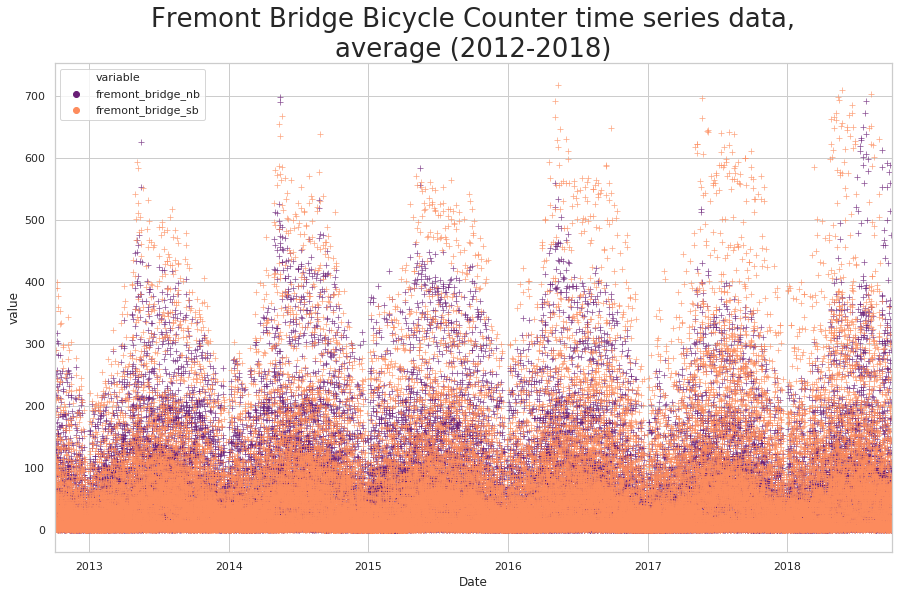

In [5]:
sns.set(style="whitegrid")
plt.subplots(figsize=(15,9))

ax = sns.scatterplot(y = agg['value'], x = agg['Date'], marker='+', hue=agg['variable'],
                    alpha = 0.75, palette=['#691E76', '#FD8C5D'])
ax.set_xlim(agg.iloc[0]['Date'], agg.iloc[len(agg) - 1]['Date'])
ax.set_title('Fremont Bridge Bicycle Counter time series data,\naverage (2012-2018)',
            fontsize=26)

> There is a cyclical, annual pattern in bicycle counts. Collapse day by summing the totals.

Text(0.5, 1.0, 'Bike traffic across Fremont Bridge time series,\nTotal cyclists per month, jittered by day (2012-2018)')

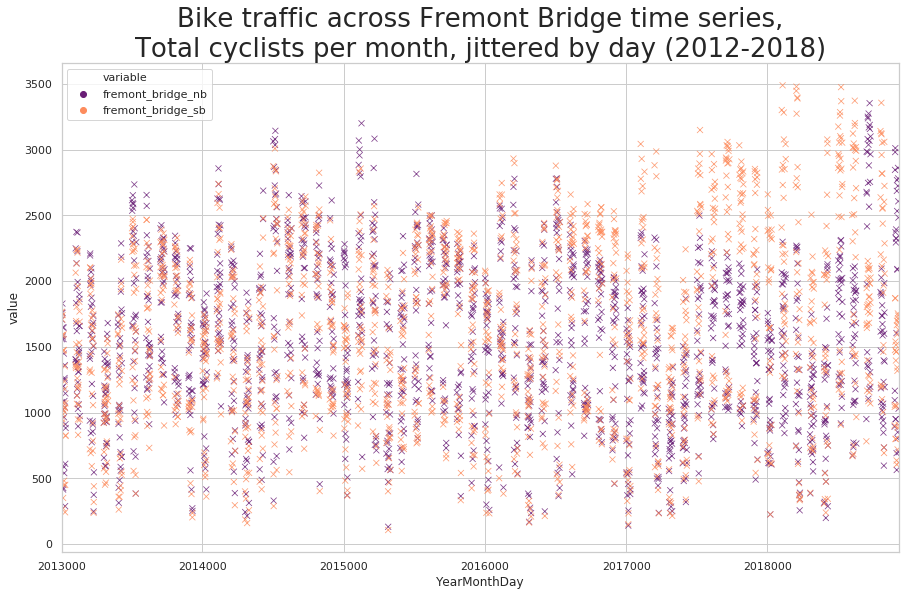

In [6]:
agg = df.groupby(by=['YearMonthDay'], as_index=False).sum()
agg = pd.melt(agg, id_vars=['YearMonthDay'], 
        value_vars=['fremont_bridge_nb', 'fremont_bridge_sb'])

# Plot
sns.set(style="whitegrid")
plt.subplots(figsize=(15,9))

ax = sns.scatterplot(y = agg['value'], x = agg['YearMonthDay'], marker='x', hue=agg['variable'],
                    alpha = 0.85, palette=['#691E76', '#FD8C5D'])
ax.set_xlim(agg.iloc[0]['YearMonthDay'], agg.iloc[len(agg) - 1]['YearMonthDay'])
ax.set_title('Bike traffic across Fremont Bridge time series,\n\
Total cyclists per month, jittered by day (2012-2018)',
            fontsize=26)

> Any trends here are more difficult to distinguish visually than above, but there is a noticeable heavier use of the 'SB' side of the bridge than the 'NB' side beginning in late 2016. 

> Now plot the data as a heatmap.

Text(0.5, 57.5, 'Julian Calendar Day (1 through 365)')

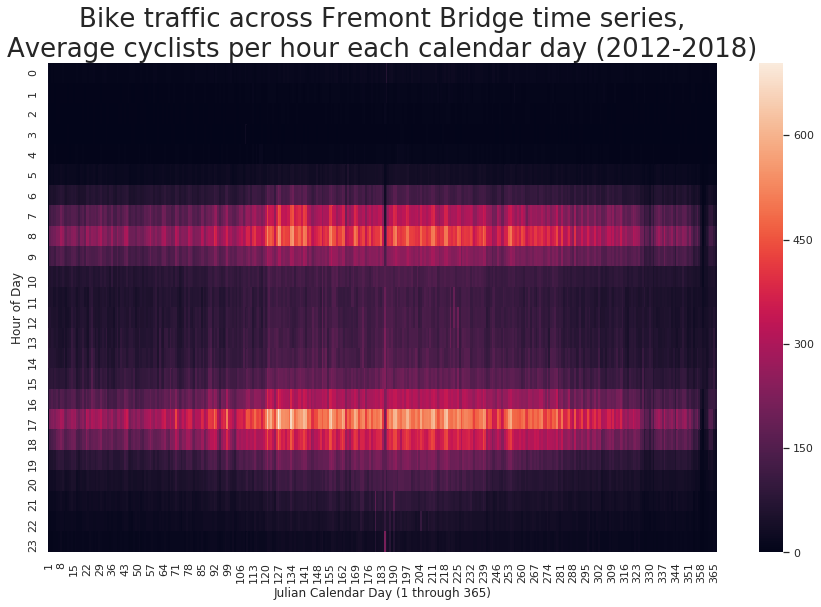

In [7]:
agg = df.groupby(by=['Day', 'Month', 'Year', 'Hour', 'Julian'], as_index=False).mean()
agg = agg.pivot_table("Total", "Hour", "Julian")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg)
ax.set_title('Bike traffic across Fremont Bridge time series,\n\
Average cyclists per hour each calendar day (2012-2018)',
            fontsize=26)
ax.set_ylabel('Hour of Day')
ax.set_xlabel('Julian Calendar Day (1 through 365)')

> There are obvious peak ridership times, most noticeably around 8:00 and 17:00 each day with visible peaks in the middle calendar days (i.e. the summer months).

Text(0.5, 57.5, 'Year & Month')

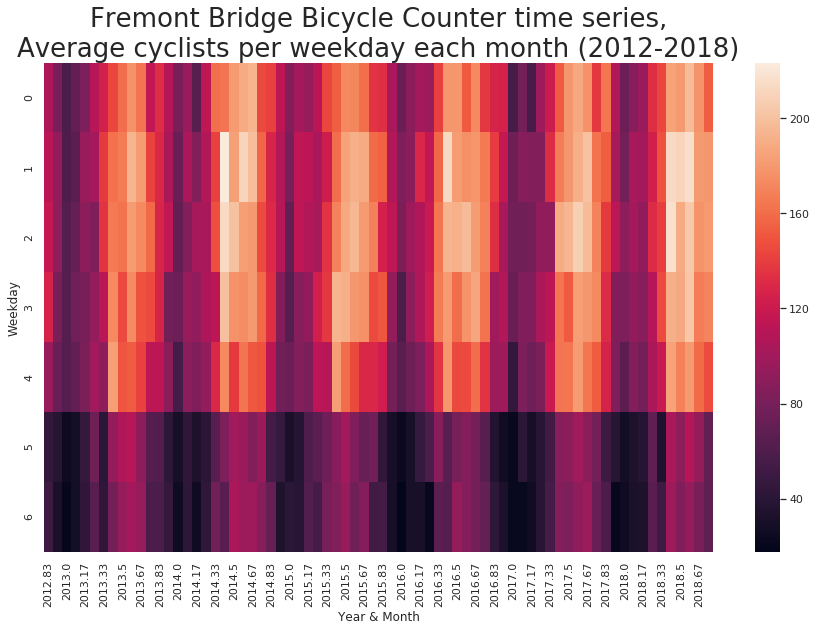

In [8]:
df['YearMonth'] = np.around(df['Year'] + df['Month']/12, 2)
agg = df.groupby(by=['Weekday', 'YearMonth'], as_index=False).mean()
agg = agg.pivot_table("Total", "Weekday", "YearMonth")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg)
ax.set_title('Fremont Bridge Bicycle Counter time series,\n\
Average cyclists per weekday each month (2012-2018)',
            fontsize=26)
ax.set_ylabel('Weekday')
ax.set_xlabel('Year & Month')

> When averaging bicycle ridership across Fremont bridge by weekday, we notice a sharp contrast in ridership between week days 4 and 5 (Friday and Saturday). This suggests that the vast majority of bicyclists who commute across Fremont Bridge are commuting to and from work.

Text(0.5, 57.5, 'Year & Month')

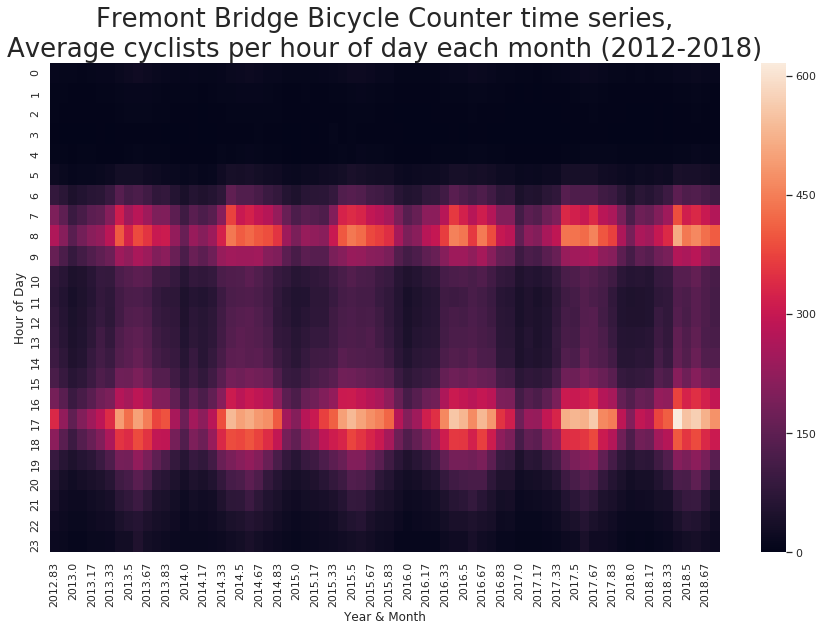

In [9]:
df['YearMonth'] = np.around(df['Year'] + df['Month']/12, 2)
agg = df.groupby(by=['Hour', 'YearMonth'], as_index=False).mean()
agg = agg.pivot_table("Total", "Hour", "YearMonth")
agg.head()

plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg)
ax.set_title('Fremont Bridge Bicycle Counter time series,\n\
Average cyclists per hour of day each month (2012-2018)',
            fontsize=26)
ax.set_ylabel('Hour of Day')
ax.set_xlabel('Year & Month')

> Here, the rush hour effect is still visible. On the face value, it appears that Fremont Bridge bicycle ridership has remained relatively constant over time, although it could be worth exploring any possible significant differences.

Text(0.5, 57.5, 'Year & Month')

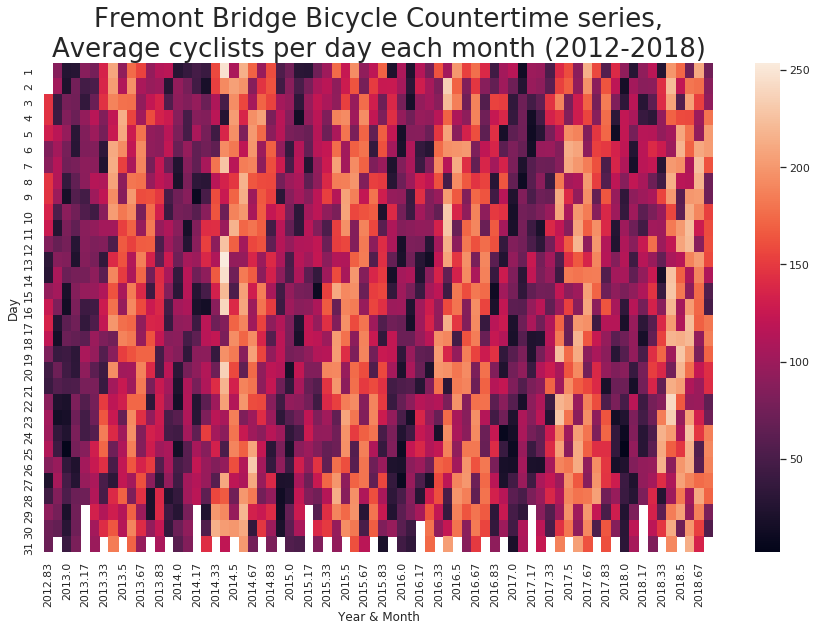

In [10]:
df['YearMonth'] = np.around(df['Year'] + df['Month']/12, 2)
agg = df.groupby(by=['Day', 'YearMonth'], as_index=False).mean()
agg = agg.pivot_table("Total", "Day", "YearMonth")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg)
ax.set_title('Fremont Bridge Bicycle Countertime series,\n\
Average cyclists per day each month (2012-2018)',
            fontsize=26)
ax.set_ylabel('Day')
ax.set_xlabel('Year & Month')

> These data look like a bunch of noise, but there is a slight diagonal offset year-to-year for bike ridership on each day of the month. This is presumably due to the one-day weekday shift for any given calendar date from one year to the next.

## Spoofs! (i.e. Beautiful mistakes)

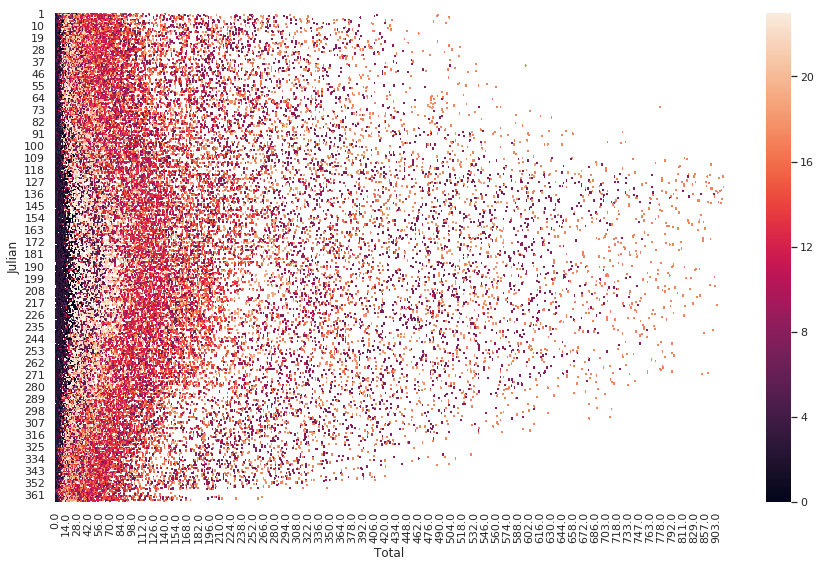

In [11]:
agg = df.groupby(by=['Day', 'Month', 'Year', 'Hour', 'Julian'], as_index=False).mean()
agg = agg.pivot_table("Hour", "Julian", "Total")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg)

> This chart I plotted early in my data exploration when I was playing around with the dataset. I thought it was too pretty to destroy, so I've left it here. Can you extract any meaning from it? 